In [ ]:
!pip install pandas


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#simulate 60 days of defect data
np.random.seed(42)
days=pd.date_range(start='2024-01-01',periods=60)
sample_size=np.random.randint(80,120,size=60)#daily sample sizes
true_defect_rate=0.05

#Simulate daily defect counts
defect_count=np.random.binomial(sample_size,true_defect_rate)

df=pd.DataFrame({
    'Date':days,
    'Sample_Size':sample_size,
    'Defects':defect_count
})

df['Defect_Rate']=df['Defects']/df['Sample_Size']
print(df.head())


C:\Users\sangw\AppData\Local\Temp\ipykernel_1992\2405679526.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


        Date  Sample_Size  Defects  Defect_Rate
0 2024-01-01          118        5     0.042373
1 2024-01-02          108        9     0.083333
2 2024-01-03           94        6     0.063830
3 2024-01-04           87        3     0.034483
4 2024-01-05          100        5     0.050000


In [ ]:
#Overall average defe t rate
p_bar=df['Defects'].sum()/df['Sample_Size'].sum()

#Control limits
df['p_bar']=p_bar
df['UCL']=p_bar + 3 * np.sqrt((p_bar * (1-p_bar))/df['Sample_Size'])
df['LCL']=p_bar - 3 * np.sqrt((p_bar * (1-p_bar))/df['Sample_Size'])
df['LCL']=df['LCL'].clip(lower=0) #LCL can't be negative

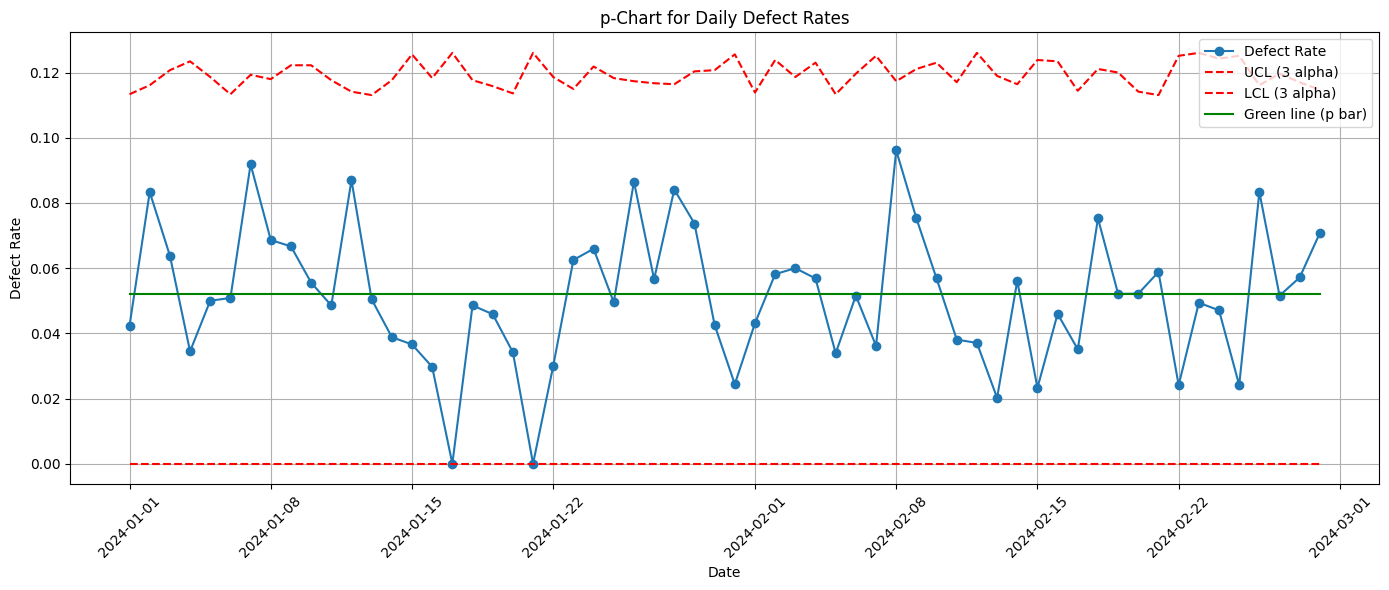

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'],df['Defect_Rate'],marker='o',label='Defect Rate')
plt.plot(df['Date'],df['UCL'],linestyle='--',color='red',label='UCL (3 alpha)')
plt.plot(df['Date'],df['LCL'],linestyle='--',color='red',label='LCL (3 alpha)')
plt.plot(df['Date'],df['p_bar'],linestyle='-',color='green',label='Green line (p bar)')
plt.title('p-Chart for Daily Defect Rates')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df['Out_of_Control']=(df['Defect_Rate']>df['UCL'])|(df['Defect_Rate']<df['LCL'])

#Show flagged days
print(df[df['Out_of_Control']][['Date','Defect_Rate','UCL','LCL']])

Empty DataFrame
Columns: [Date, Defect_Rate, UCL, LCL]
Index: []


In [ ]:
#Hypothesis Testing Example(One Proportion_ztest)
from statsmodels.stats.proportion import proportions_ztest

#test if last day's defect rate is significantly higher than average
last=df.iloc[-1]
count=last['Defects']
nobs=last['Sample_Size']
stat,pval=proportions_ztest(count,nobs,value=p_bar,alternative='larger')
print(f"Z-stat:{stat:.2f},p-value:{pval:.4f}")

if pval<0.05:
    print("Significantly significant increase in defects!")
else:
    print("No Significant shift detected.")

Z-stat:0.78,p-value:0.2181
No Significant shift detected.


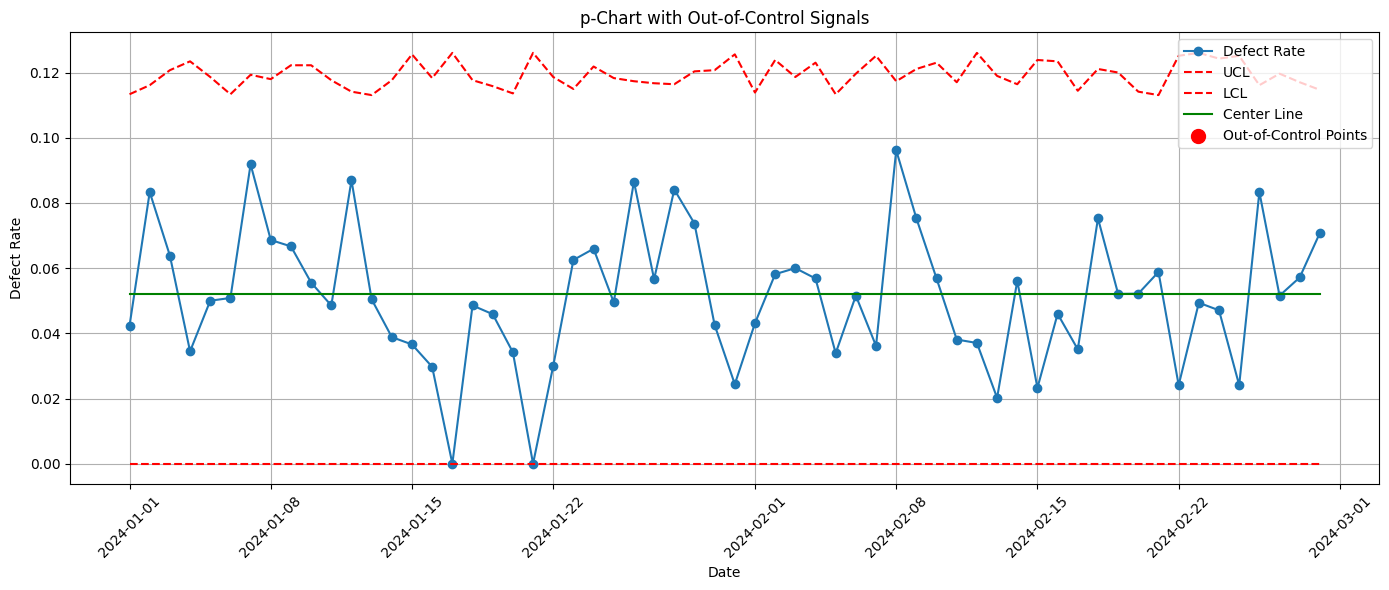

In [ ]:
#highlight out of control points
#Mark out-of-control points on the chart
plt.figure(figsize=(14,6))
plt.plot(df['Date'],df['Defect_Rate'],marker='o',label='Defect Rate')
plt.plot(df['Date'],df['UCL'],linestyle='--',color='red',label='UCL')
plt.plot(df['Date'],df['LCL'],linestyle='--',color='red',label='LCL')
plt.plot(df['Date'],df['p_bar'],linestyle='-',color='green',label='Center Line')

#highlight points
out=df[df['Out_of_Control']]
plt.scatter(out['Date'],out['Defect_Rate'],color='red',s=100,label='Out-of-Control Points')

plt.title('p-Chart with Out-of-Control Signals')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#introduce a shift in the defect rate on day 35
df.loc[35:, 'Defects']=np.random.binomial(df.loc[35:,'Sample_Size'],0.10) #double defect rate
df['Defect_Rate']=df['Defects']/df['Sample_Size']

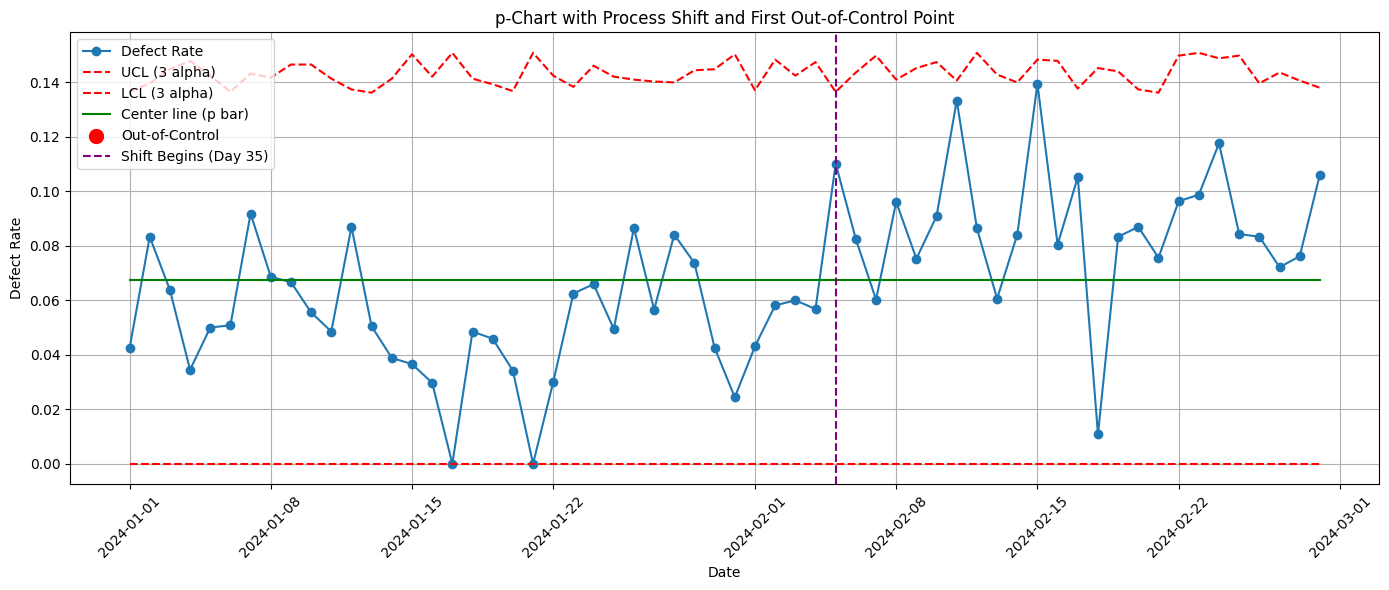

In [ ]:
import matplotlib.pyplot as plt

#Recalculate p-bar and control limits
p_bar=df['Defects'].sum()/df['Sample_Size'].sum()
df['p_bar']=p_bar
df['UCL']=p_bar + 3 * np.sqrt((p_bar * (1 - p_bar))/df['Sample_Size'])
df['lCL']=p_bar - 3 * np.sqrt((p_bar * (1 - p_bar))/df['Sample_Size'])
df['LCL']=df['LCL'].clip(lower=0)

#Flag out-of-control points
df['Out_of_Control']=(df['Defect_Rate']>df['UCL'])|(df['Defect_Rate']<df['LCL'])
out_points=df[df['Out_of_Control']]

#identify first out of control points after the shift
first_shift_index=35
first_out_after_shift=df.loc[first_shift_index:].query("Out_of_Control").head(1)

#Plot setup
plt.figure(figsize=(14,6))
plt.plot(df['Date'],df['Defect_Rate'],marker='o',label='Defect Rate')
plt.plot(df['Date'],df['UCL'],linestyle='--',color='red',label='UCL (3 alpha)')
plt.plot(df['Date'],df['LCL'],linestyle='--',color='red',label='LCL (3 alpha)')
plt.plot(df['Date'],df['p_bar'],linestyle='-',color='green',label='Center line (p bar)')
plt.scatter(out_points['Date'],out_points['Defect_Rate'],color='red',s=100,zorder=5,label='Out-of-Control')
plt.axvline(df['Date'].iloc[first_shift_index],color='purple',linestyle='--',label='Shift Begins (Day 35)')

#Add annotation to first out-of-control point after shift
if not first_out_after_shift.empty:
    x=first_out_after_shift['Date'].values[0]
    y=first_out_after_shift['Defect_Rate'].values[0]
    plt.annotate(
        'First out-of-control',
        xy-(x,y),
        xytext=(x,y+0.02),
        arrowpops=dict(facecolor='black',shrink=0.05),
        fontsize=10,
        ha='center'
    )
#Labels and Layout
plt.title('p-Chart with Process Shift and First Out-of-Control Point')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

#Step 1:Estimate standard deviation for each row
df['sigma']=np.sqrt((df['p_bar'] * (1 - df['p_bar'])) / df['Sample_Size'])

#Step 2:compute 1alpha and 2alpha boundaries
df['Upper_1sigma']=df['p_bar']+df['sigma']
df['Lower_1sigma']=df['p_bar']-df['sigma']
df['Upper_2sigma']=df['p_bar']+2*df['sigma']
df['Lower_2sigma']=df['p_bar']-2*df['sigma']

#Rule 1:One point beyond UCL or LCL
df['Rule1']=(df['Defect_Rate']>df['UCL'])|(df['Defect_Rate']<df['LCL'])

#Rule 2: 2 of 3 consecutive points beyond 2alpha(same side)
rule2_flags=[False]*len(df)
for i in range(2,len(df)):
    upper=(df.loc[i-2:i,'Defect_Rate']>df.loc[i-2:i,'Upper_2sigma']).sum()
    lower=(df.loc[i-2:i,'Defect_Rate']>df.loc[i-2:i,'Lower_2sigma']).sum()
    rule2_flags[i]=(upper >= 2)or (lower >= 2)
df['Rule2']=rule2_flags

#Rule 4: 8 points in a row on same side of center line
df['Above_Center']=df['Defect_Rate']>df['p_bar']
run_lengths=[1]
for i in range(1,len(df)):
    if df.loc[i,'Above_Center']==df.loc[i-1,'Above_Center']:
        run_lengths.append(run_lengths[-1]+1)
    else:
        run_lengths.append(1)
df['Run_Length']=run_lengths
df['Rule4']=df['Run_Length']>=8

#Combine RUles
df['Any_Rule_Violation']=df[['Rule1','Rule2','Rule4']].any(axis=1)

#View violations
violations=df[df['Any_Rule_Violation']]
print(violations[['Date','Defect_Rate','Rule1','Rule2','Rule4']])

         Date  Defect_Rate  Rule1  Rule2  Rule4
2  2024-01-03     0.063830  False   True  False
3  2024-01-04     0.034483  False   True  False
4  2024-01-05     0.050000  False   True  False
5  2024-01-06     0.050847  False   True  False
6  2024-01-07     0.091837  False   True  False
7  2024-01-08     0.068627  False   True  False
8  2024-01-09     0.066667  False   True  False
9  2024-01-10     0.055556  False   True  False
10 2024-01-11     0.048544  False   True  False
11 2024-01-12     0.086957  False   True  False
12 2024-01-13     0.050420  False   True  False
13 2024-01-14     0.038835  False   True  False
14 2024-01-15     0.036585  False   True  False
15 2024-01-16     0.029703  False   True  False
16 2024-01-17     0.000000  False   True  False
17 2024-01-18     0.048544  False   True  False
18 2024-01-19     0.045872  False   True  False
19 2024-01-20     0.034188  False   True   True
20 2024-01-21     0.000000  False   True   True
21 2024-01-22     0.030000  False   True

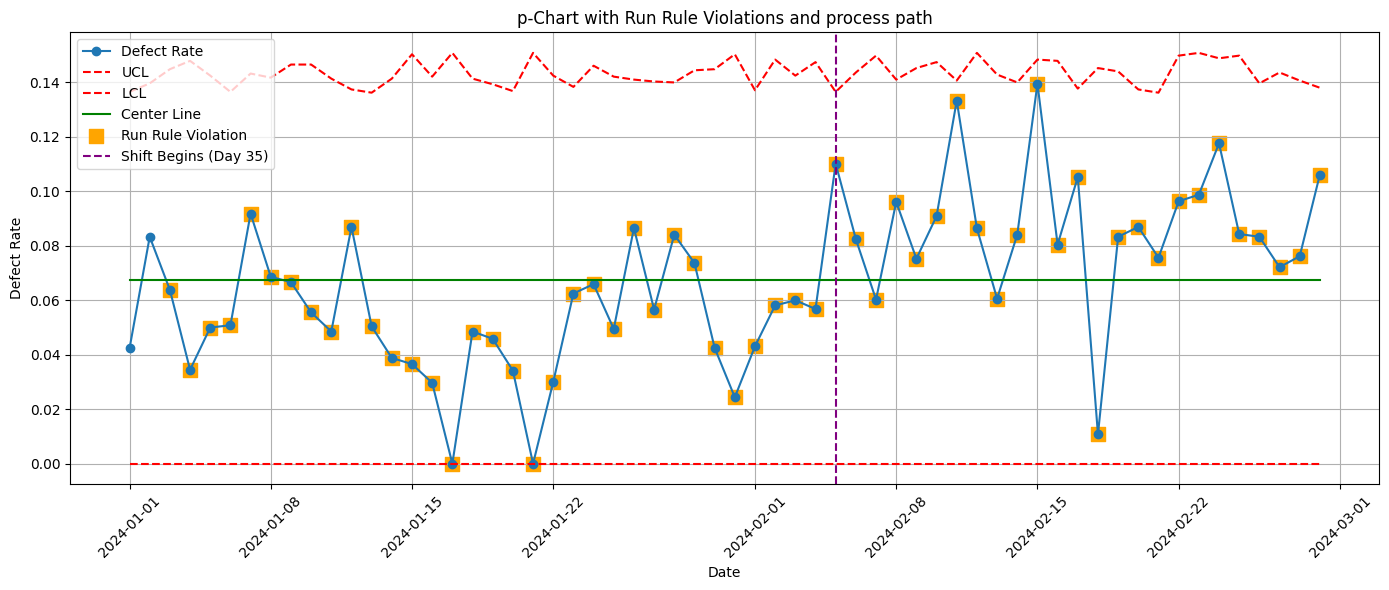

In [ ]:
#Plot with violations highlighted
plt.figure(figsize=(14,6))

#Main defect rate line
plt.plot(df['Date'],df['Defect_Rate'],marker='o',label='Defect Rate')

#Control limits and center
plt.plot(df['Date'],df['UCL'],linestyle='--',color='red',label='UCL')
plt.plot(df['Date'],df['LCL'],linestyle='--',color='red',label='LCL')
plt.plot(df['Date'],df['p_bar'],linestyle='-',color='green',label='Center Line')

#highlight violations
plt.scatter(violations['Date'],violations['Defect_Rate'],
           color='orange',s=100,marker='s',label='Run Rule Violation')

#Add shift marker
plt.axvline(df['Date'].iloc[35],color='purple',linestyle='--',label='Shift Begins (Day 35)')

#final touches
plt.title('p-Chart with Run Rule Violations and process path')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Assume specs: acceptable defect rate between 2% and 8%
USL,LSL=0.08,0.02
process_sigma=df['Defect_Rate'].std()

Cp=(USL - LSL)/(6*process_sigma)
Cpk=min((USL - p_bar), (p_bar - LSL)) / (3 * process_sigma)

print(f"Cp: {Cp:.2f}, Cpk: {Cpk:.2f}")

Cp: 0.34, Cpk: 0.14


In [ ]:
#Bootstraping for confidence intervals
boot_means=[np.mean(np.random.choice(df['Defect_Rate'],size=len(df),replace=True)) for _ in range(1000)]
ci_lower = np.percentile(boot_means,2.5)
ci_upper = np.percentile(boot_means,97.5)
print(f"95% CI for average defect rate:({ci_lower:.4f},{ci_upper:.4f})")

95% CI for average defect rate:(0.0602,0.0743)


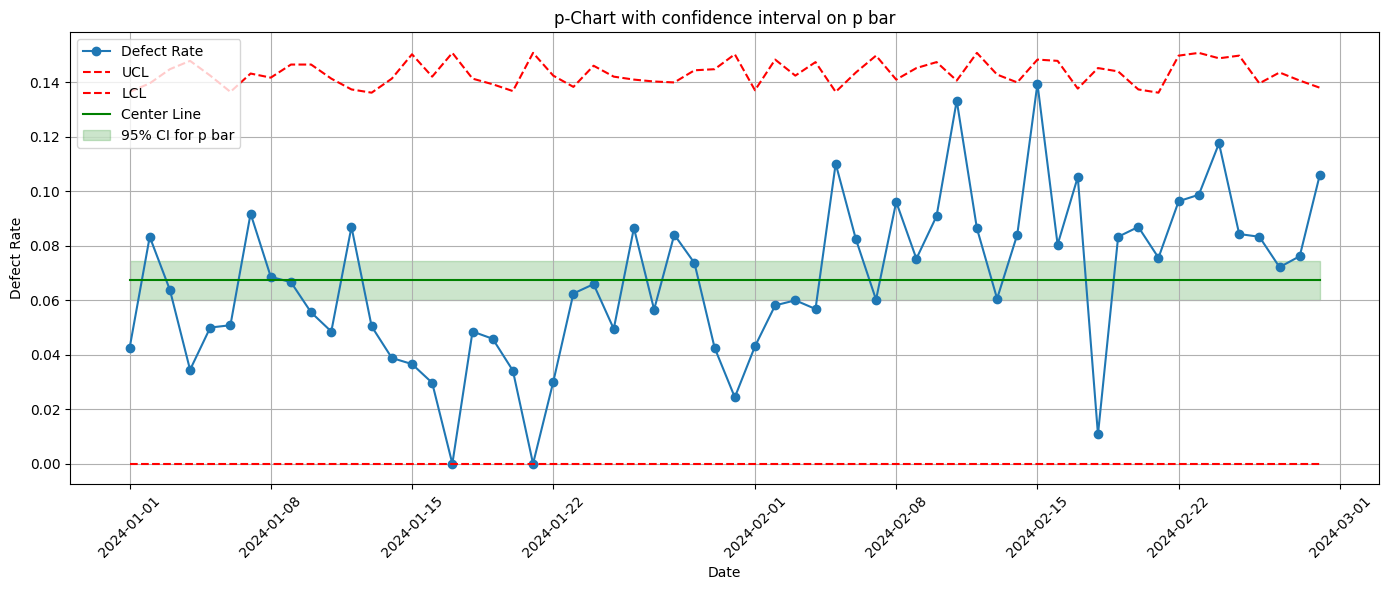

In [ ]:
#Existing chart
plt.figure(figsize=(14,6))
plt.plot(df['Date'],df['Defect_Rate'],marker='o',label='Defect Rate')

#Control limits and center
plt.plot(df['Date'],df['UCL'],linestyle='--',color='red',label='UCL')
plt.plot(df['Date'],df['LCL'],linestyle='--',color='red',label='LCL')
plt.plot(df['Date'],df['p_bar'],linestyle='-',color='green',label='Center Line')

# Add this for confidence interval shading

plt.fill_between(
    df['Date'],ci_lower,ci_upper,
    color='green',alpha=0.2,label='95% CI for p bar'
)

#Finalize chart
plt.title('p-Chart with confidence interval on p bar')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
#Step 1:Create a numeric "Day" column
df['Day']=range(1,len(df) + 1)

#Step 2:Run linerar regression on defect rate over time
trend_result=linregress(df['Day'],df['Defect_Rate'])

slope=trend_result.slope
p_value=trend_result.pvalue
intercept=trend_result.intercept

#Step 3:Create trend line values
df['Trend_Line']=intercept+slope*df['Day']

#Step 4:Plot p-chart with trend line
plt.figure(figsize=(14,6))
plt.plot(df['Date'],df['Defect_Rate'],marker='o',label='Defect Rate')
plt.plot(df['Date'],df['UCL'],linestyle='--',color='red',label='UCL (3-alpha)')
plt.plot(df['Date'],df['LCL'],linestyle='--',color='red',label='LCL (3-alpha)')
plt.plot(df['Date'],df['p_bar'],linestyle='-',color='green',label='Center Line (p-bar)')

#Add trend line
plt.plot(df['Date'],df['Trend_Line'],linestyle='--',color='blue',linewidht=2,label='Trend Line')

#Step 5:Annotate with slope and p-value
plt.text(df['Date'].iloc[2], max(df['Defect Rate']),
        f"Slope:{slope:.4f}\nP-value:{p_value:.4f}",
        fontsize=10,bbox=dict(facecolor='white',edgecolor)
        )


SyntaxError: positional argument follows keyword argument (816953396.py, line 29)

In [ ]:
#CUSUM parameters
target=df['Defect_Rate'].mean()
k=0.005 #Refrence value (tuning sensitivity)
h=0.5 #Decision threshold

#Initialize lists
cusum_pos=[0]
cusum_neg=[0]

#Calculate  CUMSUM values
for i in range(1,len(df)):
    p_i=df.loc[i,'Defect_Rate']
    s_pos=max(0,cusum_pos[-1]+(p_i - target - k))
    s_neg=min(0,cusum_neg[-1]+(p_i - target + k))
    cusum_pos.append(s_pos)
    cusum_neg.append(s_neg)

#Add to Dataframe
df['CUSUM_Pos']=cusum_pos
df['CUSUM_Neg']=cusum_neg

#Plot CUMSUM
plt.figure(figsize=(14,6))
plt.plot(df['Date'],df['CUSUM_Pos'],label='CUSUM +',color='blue')
plt.plot(df['Date'],df['CUSUM_Neg'],label='CUSUM -',color='orange')
plt.axhline(h,color='red', linestyle='--',label='Contol limit (+)')
plt.axhline(-h,color='red',linestyle='--',label='Control limit (-)')
plt.axhline(0,color='black',linestyle='-')
plt.title('CUSUM Chart for Defect Rate')
plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#EWMA Parameters
lambda_ = 0.2 #Smoothing constant
L = 3 #Control limit multiplier

#Initialize EWMA
df['EWMA']=0.0
df.loc[0,'EWMA']=df.loc[0,'Defect_Rate']

#Compute EWMA for each day
for i in range(1,len(df)):
    df.loc[i,'EWMA']=lambda_ * df.loc[i,'Defect_Rate']+(1-lambda_)*df.loc[i-1,'EWMA']

#Estimate sigma (average over entire series)
p_bar=df['Defect_Rate'].mean()
avg_n=df['Sample_Size'].mean()
sigma=np.sqrt((p_bar * (1-p_bar))/avg_n)

#Control Limits
df['UCL_EWMA']=p_bar + L * sigma * np.sqrt(lambda_ / (2 - lambda_))
df['LCL_EWMA']=p_bar - L * sigma * np.sqrt(lambda_ / (2 - lambda_))

#Plot EWMA
plt.figure(figsize=(14,6))
plt.plot(df['Date'],df['EWMA'], marker='o', label='EWMA')
plt.plot(df['Date'],df['UCL_EWMA'],linestyle='--',color='red',label='UCL')
plt.plot(df['Date'],df['LCL_EWMA'],linestyle='--',color='red',label='LCL')
plt.axhline(p_bar,color='green',linestyle='-',label='Center Line')
plt.title('EWMA Chart for Defect Rate')
plt.xlabel('Date')
plt.ylabel('EWMA of Defect Rate')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Recalculate needed KPIs
avg_defect_rate=df['Defect_Rate'].mean()
max_defect_rate=df['Defect_Rate'].max()
min_defect_rate=df['Defect_Rate'].min()
out_of_control_days=(df['CUSUM_Pos']>0.05).sum() + (df['CUSUM_Neg']<0.05).sum()

#Create subplot grid
fig,axs=plt.subplots(3,2,figsize=(16,12))
fig.suptitle('Quality Control KPI Dashboard',fontsize=18,fontweight='bold')

#1.Daily Defect Rate
axs[0,0].plot(df['Date'],df['Defect_Rate'],marker='o',color='blue')
axs[0,0].axhline(avg_defect_rate,color='green',linestyle='--',label='Average')
axs[0,0].set_title('Daily Defect Rate')
axs[0,0].set_ylabel('Defect Rate')
axs[0,0].legend()
axs[0,0].grid(True)

#2.EWMA Chart

axs[0,1].plot(df['Date'],df['EWMA'],marker='o',label='EWMA',color='orange')
axs[0,1].plot(df['Date'],df['UCL_EWMA'],linestyle='--',color='red',label='UCL')
axs[0,1].plot(df['Date'],df['LCL_EWMA'],linestyle='--',color='red',label='LCL')
axs[0,1].axhline(avg_defect_rate,color='green',linestyle='-',label='Target')
axs[0,1].set_title('EWMA Chart')
axs[0,1].legend()
axs[0,1].grid(True)

#3. CUSUM Chart
axs[1,0].plot(df['Date'],df['CUSUM_Pos'],label='CUSUM +',color='blue')
axs[1,0].plot(df['Date'],df['CUSUM_Neg'],label='CUSUM -',color='orange')
axs[1,0].axhline(0.05,color='red',linestyle='--')
axs[1,0].axhline(-0.05,color='red',linestyle='--')
axs[1,0].set_title('CUSUM Chart')
axs[1,0].grid(True)
axs[1,0].legend()

#4. Boxplot of defect rates
axs[1,1].boxplot(df['Defect_Rate'],vert=False)
axs[1,1].set_title('Defect Rate Distribution')
axs[1,1].set_xlabel('Defect Rate')
axs[1,1].grid(True)

#5. KPI Summary
axs[2,0].axis('off')
kpi_text = f"""
Summary KPIs:
-Average Defect Rate: {avg_defect_rate:.4f}
-Max Defect Rate:     {max_defect_rate:.4f}
-Min Defect Rate:     {min_defect_rate:.4f}
-Out-of-Control Days (CUSUM): {out_of_control_days}
-Days Monitored:      {len(df)}

Note: Control limits use pbar +- 3alpha.EWMA Lambda=0.2.
"""

axs[2,0].text(0.01,0.9,kpi_text,fontsize=12,verticalalignment='top',family='monospace')

#6. Empty Space or add more content
axs[2,1].axis('off') #Placeholder for future KPI

plt.tight_layout(rect=[0,0.3,1,0.95])
plt.show()